In [67]:
#Importing Libraries
import numpy as np
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [54]:
# load and process data, also taking help of MS Excel in the process
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(r'C:\Users\Kushagra\Documents\AQI DATA\data1.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution1.csv')


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


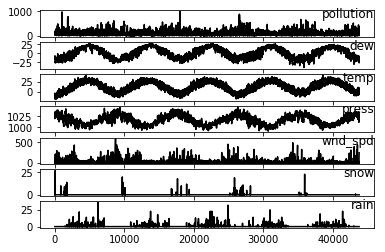

In [55]:
# generating dataset plot
from pandas import read_csv
from matplotlib import pyplot
dataset = read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group],'k')
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [56]:
# Lets normalize all features, and remove the weather variables for the hour to be predicted.
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def s_to_super(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [57]:
# load dataset
dataset = read_csv(r'C:\Users\Kushagra\Documents\AQI DATA\pollution1.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = s_to_super(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [58]:
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (8760, 1, 8) (8760,)  Testing data shape X, y =>  (35039, 1, 8) (35039,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [60]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adam version of stochastic gradient descent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.3004 - accuracy: 0.0763 - val_loss: 0.1332 - val_accuracy: 0.0393
Epoch 2/50
 - 1s - loss: 0.0935 - accuracy: 0.0764 - val_loss: 0.0749 - val_accuracy: 0.0393
Epoch 3/50
 - 1s - loss: 0.0766 - accuracy: 0.0764 - val_loss: 0.0713 - val_accuracy: 0.0393
Epoch 4/50
 - 1s - loss: 0.0733 - accuracy: 0.0764 - val_loss: 0.0686 - val_accuracy: 0.0393
Epoch 5/50
 - 1s - loss: 0.0701 - accuracy: 0.0764 - val_loss: 0.0657 - val_accuracy: 0.0393
Epoch 6/50
 - 1s - loss: 0.0661 - accuracy: 0.0764 - val_loss: 0.0627 - val_accuracy: 0.0393
Epoch 7/50
 - 1s - loss: 0.0621 - accuracy: 0.0764 - val_loss: 0.0591 - val_accuracy: 0.0393
Epoch 8/50
 - 1s - loss: 0.0568 - accuracy: 0.0764 - val_loss: 0.0548 - val_accuracy: 0.0393
Epoch 9/50
 - 1s - loss: 0.0504 - accuracy: 0.0764 - val_loss: 0.0504 - val_accuracy: 0.0393
Epoch 10/50
 - 1s - loss: 0.0441 - accuracy: 0.0763 - val_loss: 0.0460 - val_accuracy: 0.0393
Epoch 11/50
 - 1s - 

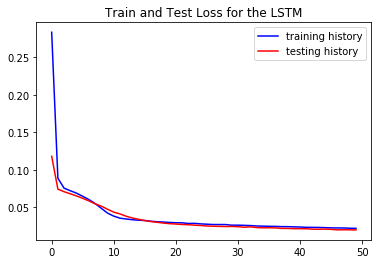

Test RMSE: 18.982


In [25]:
# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()
# evaluating model
# make a prediction
from math import sqrt
from numpy import concatenate
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


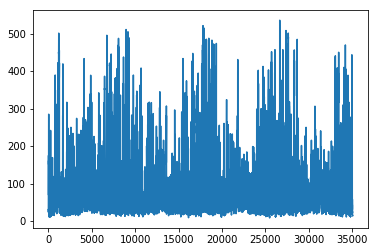

In [86]:
pyplot.plot(inv_yhat)


In [74]:
def RMSE(inv_yhat, inv_y):
    return np.sqrt(((inv_yhat - inv_y) ** 2).mean())
print ('My RMSE: ' + str(RMSE(inv_yhat,inv_y)) )


My RMSE: 18.98248


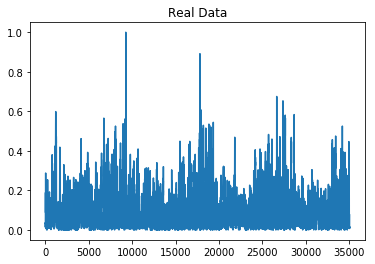

In [110]:
pyplot.plot(test_y)
pyplot.title("Real Data")
pyplot.show()

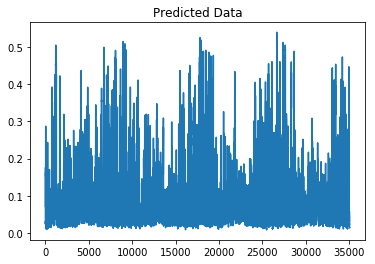

In [111]:
pyplot.plot(yhat)
pyplot.title("Predicted Data")
pyplot.show()

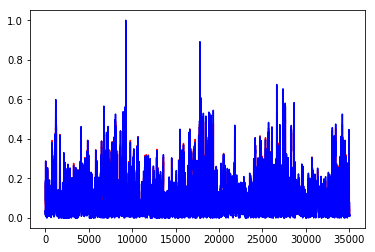

In [101]:
pyplot.plot(yhat, 'r', label='Predictions')
pyplot.plot(test_y, 'b', label='Original')

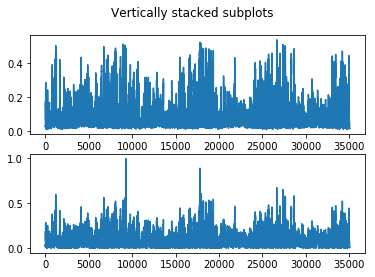

In [103]:
fig, axs = pyplot.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(yhat)
axs[1].plot(test_y)

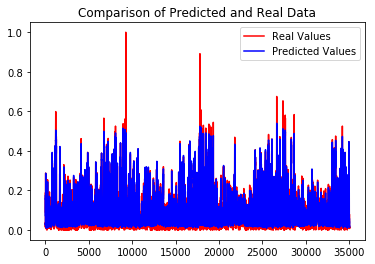

In [108]:
pyplot.plot(test_y, 'r', label='Real Values')
pyplot.plot(yhat, 'b', label='Predicted Values')
pyplot.title("Comparison of Predicted and Real Data")
pyplot.legend()